In [1]:
!pip install tweepy
!pip install configparser
!pip install spacy
!pip install googlemaps
!pip install tweet-preprocessor
!pip install pycontractions
!pip install WordCloud
!pip install emoji

In [62]:
import configparser
import numpy as np
import pandas as pd
import googlemaps
import tweepy
import string
import re #regular expression
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pycontractions import Contractions
import emoji

import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
from wordcloud import WordCloud, STOPWORDS
import os  # for os commands
plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline

import gensim.downloader as api
# Choose model accordingly for contractions function
model = api.load("glove-twitter-25")
# model = api.load("glove-twitter-100")
cont = Contractions(kv_model=model)
cont.load_models()

import urllib3.contrib.pyopenssl
urllib3.contrib.pyopenssl.inject_into_urllib3()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karthi.ponnusamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/karthi.ponnusamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/karthi.ponnusamy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
config = configparser.RawConfigParser()
config.read('twitter.properties')
print(config.sections())

['twitter']


In [7]:
accesstoken=config.get('twitter','accesstoken')
accesstokensecret=config.get('twitter','accesstokensecret')
apikey=config.get('twitter','apikey')
apikeysecret=config.get('twitter','apikeysecret')
googleapikey=config.get('twitter','googleapikey')

In [8]:
auth = tweepy.OAuthHandler(apikey,apikeysecret)
auth.set_access_token(accesstoken,accesstokensecret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [9]:
search_words = "#circuitbreakersg"

In [10]:
tweets = tweepy.Cursor(api.search,q = '{} -filter:retweets'.format(search_words), lang="en", tweet_mode="extended").items(1000)
tweet_details = [[tweet.created_at, tweet.full_text, tweet.user.screen_name, tweet.user.location] for tweet in tweets]
df_tw = pd.DataFrame(data = tweet_details, columns=['created_at', 'text', 'user', 'location'])

In [11]:
df_tw.shape

(682, 4)

In [12]:
df_tw.head()

,created_at,text,user,location
0,2020-04-14 01:42:14,Do all parents of childcare age kids automatic...,vinyarb,Singapore
1,2020-04-14 01:42:04,#circuitbreakingorange day 8 - presents for th...,hongruilee,Singapore
2,2020-04-14 01:37:40,New cases of coronavirus reach high of 386 in ...,MVresistance,
3,2020-04-14 01:31:04,#hardtruth\n\nThis was such a faux pas that PA...,freetrooper,
4,2020-04-14 01:22:02,Singapore reported 386 new COVID-19 cases on A...,septian,Singapore


In [13]:
df_tw.to_csv('circuitbreakersg_682.csv', encoding='utf-8')

In [14]:
df = pd.read_csv('circuitbreakersg_682.csv', index_col=0, parse_dates=['created_at'])

In [15]:
df.head()

,created_at,text,user,location
0,2020-04-14 01:42:14,Do all parents of childcare age kids automatic...,vinyarb,Singapore
1,2020-04-14 01:42:04,#circuitbreakingorange day 8 - presents for th...,hongruilee,Singapore
2,2020-04-14 01:37:40,New cases of coronavirus reach high of 386 in ...,MVresistance,NaN
3,2020-04-14 01:31:04,#hardtruth\n\nThis was such a faux pas that PA...,freetrooper,NaN
4,2020-04-14 01:22:02,Singapore reported 386 new COVID-19 cases on A...,septian,Singapore


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  682 non-null    datetime64[ns]
 1   text        682 non-null    object        
 2   user        682 non-null    object        
 3   location    553 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 26.6+ KB


## Data pre processing 

In [17]:
def expand_contractions(text):
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

In [18]:
def get_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

In [19]:
def remove_special_characters(text):
    return re.sub(r"\W+|_", " ", text)

In [274]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [20]:
# we will be using few python libraries for the purpose of cleaning twitter text

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

def clean_tweets(raw_tweet):
    tweet = p.clean(expand_contractions(raw_tweet))

    #remove emojis from tweet
    tweet = get_emoji_free_text(tweet)
    
    #remove special characters
    tweet = remove_special_characters(tweet)
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)

    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #print(word_tokens)
    
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)


In [21]:
df['clean_text'] = df['text'].apply(lambda x :clean_tweets(x))

In [22]:
df['tweet_hour'] = pd.DatetimeIndex(df['created_at']).hour

In [23]:
df.head(100)

,created_at,text,user,location,clean_text,tweet_hour
0,2020-04-14 01:42:14,Do all parents of childcare age kids automatic...,vinyarb,Singapore,Do parents childcare age kids automatically ge...,1
1,2020-04-14 01:42:04,#circuitbreakingorange day 8 - presents for th...,hongruilee,Singapore,day presents missus arrived Amazon More food A...,1
2,2020-04-14 01:37:40,New cases of coronavirus reach high of 386 in ...,MVresistance,NaN,New cases coronavirus reach high Singapore,1
3,2020-04-14 01:31:04,#hardtruth\n\nThis was such a faux pas that PA...,freetrooper,NaN,This faux pas PAP HQ officially announce stop ...,1
4,2020-04-14 01:22:02,Singapore reported 386 new COVID-19 cases on A...,septian,Singapore,Singapore reported new COVID 19 cases Apr comm...,1
...,...,...,...,...,...,...
95,2020-04-13 05:53:19,Plant mail is the best mail. Thank you pick.a....,avarenity,onboard my Orbiter,Plant mail best mail Thank pick plant epic fas...,5
96,2020-04-13 05:43:24,Insightful analysis of #Singapore during this ...,paepaesays,Singapore,Insightful analysis situation Go team reported...,5
97,2020-04-13 05:39:40,i wonder if i will come out of the #CCB with m...,intrepidynamite,Singapore,wonder come muscles belly,5
98,2020-04-13 05:30:35,Day 7: Tips for CB\n\n#SGUnited \n#COVIDー19 \n...,GameOnSGP,Singapore,Day Tips CB,5


## Tweet Analysis

### Number of tweets per hour

In [339]:
df['tweet_hour'].value_counts()

14    40
13    32
5     29
20    29
8     28
12    28
4     28
15    27
6     27
3     24
2     22
19    22
9     20
7     20
17    19
10    19
11    19
16    18
1     14
18    12
0     11
23     8
22     3
21     1
Name: tweet_hour, dtype: int64

In [24]:
df.to_csv('circuitbreakersg_682_stage_1.csv', encoding='utf-8')

In [25]:
df.head()

,created_at,text,user,location,clean_text,tweet_hour
0,2020-04-14 01:42:14,Do all parents of childcare age kids automatic...,vinyarb,Singapore,Do parents childcare age kids automatically ge...,1
1,2020-04-14 01:42:04,#circuitbreakingorange day 8 - presents for th...,hongruilee,Singapore,day presents missus arrived Amazon More food A...,1
2,2020-04-14 01:37:40,New cases of coronavirus reach high of 386 in ...,MVresistance,NaN,New cases coronavirus reach high Singapore,1
3,2020-04-14 01:31:04,#hardtruth\n\nThis was such a faux pas that PA...,freetrooper,NaN,This faux pas PAP HQ officially announce stop ...,1
4,2020-04-14 01:22:02,Singapore reported 386 new COVID-19 cases on A...,septian,Singapore,Singapore reported new COVID 19 cases Apr comm...,1


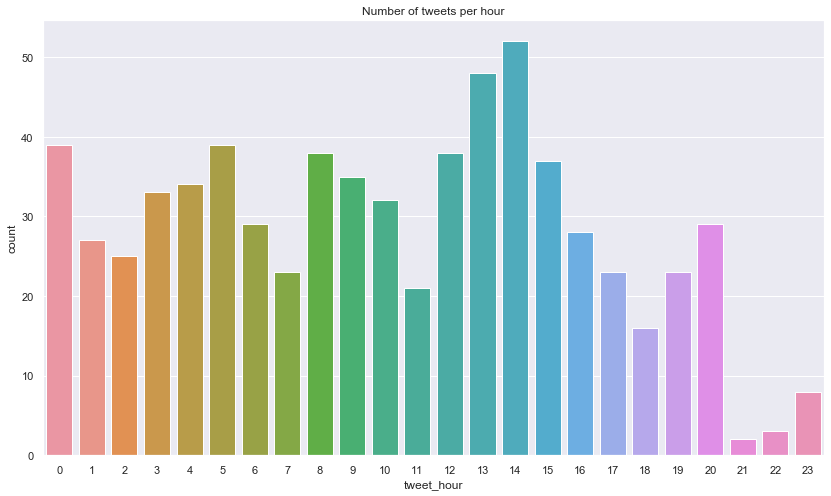

In [60]:
#Set the width and height of the figure
plt.figure(figsize=(14,8))
plt.title("Number of tweets per hour")

sns.set(style="darkgrid")
sns.countplot(x='tweet_hour', data=df)

## Sentiment Analysis


In [27]:
def calculate_sentiment_type(sentiment_compound):
    if sentiment_compound >= 0.4:
        return 'POSITIVE'
    elif sentiment_compound < 0.4 and sentiment_compound >= 0:
        return 'NEUTRAL'
    else:
        return 'NEGATIVE'

In [28]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['clean_text'].apply(lambda x:sia.polarity_scores(x))

In [29]:
df_sentiment = pd.json_normalize(df['sentiment'])
df_sentiment.columns = ['sentiment_'+x for x in df_sentiment.columns]
df_sentiment['sentiment_type'] = df_sentiment['sentiment_compound'].apply(lambda x :calculate_sentiment_type(x))
df_sentiment.head()
df = pd.concat([df, df_sentiment], axis=1)

In [30]:
df.head()

,created_at,text,user,location,clean_text,tweet_hour,sentiment,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment_type
0,2020-04-14 01:42:14,Do all parents of childcare age kids automatic...,vinyarb,Singapore,Do parents childcare age kids automatically ge...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NEUTRAL
1,2020-04-14 01:42:04,#circuitbreakingorange day 8 - presents for th...,hongruilee,Singapore,day presents missus arrived Amazon More food A...,1,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...",0.000,0.825,0.175,0.1779,NEUTRAL
2,2020-04-14 01:37:40,New cases of coronavirus reach high of 386 in ...,MVresistance,NaN,New cases coronavirus reach high Singapore,1,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",0.000,0.820,0.180,0.0258,NEUTRAL
3,2020-04-14 01:31:04,#hardtruth\n\nThis was such a faux pas that PA...,freetrooper,NaN,This faux pas PAP HQ officially announce stop ...,1,"{'neg': 0.206, 'neu': 0.794, 'pos': 0.0, 'comp...",0.206,0.794,0.000,-0.5267,NEGATIVE
4,2020-04-14 01:22:02,Singapore reported 386 new COVID-19 cases on A...,septian,Singapore,Singapore reported new COVID 19 cases Apr comm...,1,"{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...",0.000,0.899,0.101,0.4466,POSITIVE


In [31]:
df.to_csv('circuitbreakersg_682_stage_2.csv', encoding='utf-8')

In [32]:
df['sentiment_type'].value_counts()

NEUTRAL     344
POSITIVE    214
NEGATIVE    124
Name: sentiment_type, dtype: int64

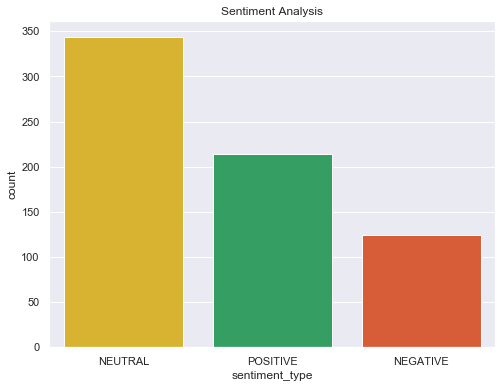

In [33]:
#Set the width and height of the figure
plt.figure(figsize=(8,6))
plt.title("Sentiment Analysis")

sns.set(style="darkgrid")
sns.countplot(x='sentiment_type', data=df, palette=["#F3C217", "#24AF60", "#F24E1D"], order = df['sentiment_type'].value_counts().index)

### Tweet hour vs Sentiment per day

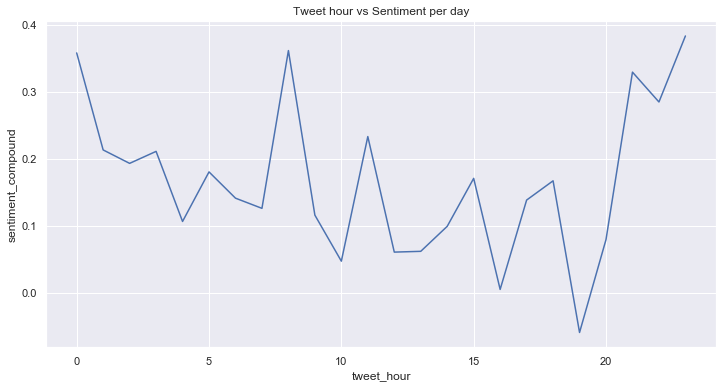

In [34]:
plt.figure(figsize=(12,6))
plt.title("Tweet hour vs Sentiment per day")

sns.set(style="darkgrid")
df_line=(df.groupby('tweet_hour',as_index=False).sentiment_compound.mean())
sns.lineplot(x='tweet_hour', y='sentiment_compound', data=df_line)


## Most discussed topics

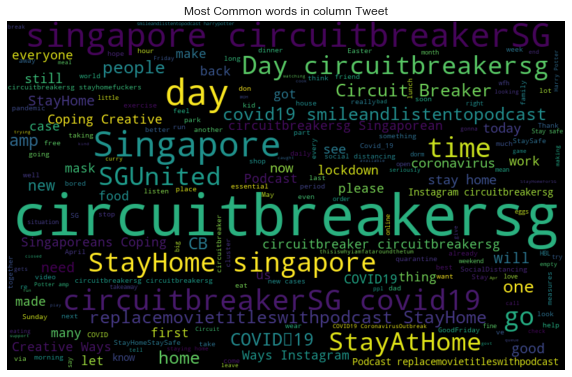

In [36]:
all_words = ' '.join([text for text in df['text']])

# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in all_words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(
    width=800, 
    height=500, 
    random_state=21, 
    max_font_size=110
).generate(no_urls_no_tags)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet")
plt.show()

## Fetching tweet location


In [37]:
df['location'].value_counts()

Singapore                        331
3 A.M.                            45
Mercury, France                   20
singapore                          9
North-East Region, Singapore       7
                                ... 
North-East Singapore               1
Newcastle Upon Tyne, England       1
chilly house of cards              1
N 1� 18' 0'' / E 103� 52' 0''      1
1.3521° N, 103.8198° E             1
Name: location, Length: 89, dtype: int64

In [43]:
gmaps = googlemaps.Client(key=googleapikey)

In [44]:
def get_country(input):
    #print(input)
    #print(type(input))
    
    if type(input) == str:
        if(not input.strip()):
            return 'Unknown location'
        else:
            if 'singapore' in input.lower():
                return 'Singapore'
            else:
                try:
                    output = gmaps.geocode(input)[0]['formatted_address'].split(",")[-1].strip()
                except Exception as e:
                    output = 'Unknown location'
                return output
    else:
        return 'Unknown location'

In [45]:
df['country'] = df['location'].apply(lambda x: get_country(x))

## Tweets by location

In [46]:
df['country'].value_counts()

Singapore           395
Unknown location    161
USA                  74
France               20
Malaysia              8
Thailand              3
Asia                  3
Japan                 2
Pakistan              2
Philippines           2
India                 2
Australia             2
Singapore 460016      1
Hong Kong             1
Mexico                1
UK                    1
China                 1
Canada                1
Singapore 460132      1
Antarctica            1
Name: country, dtype: int64

In [47]:
df_tw.to_csv('circuitbreakersg_682_stage_3.csv', encoding='utf-8')

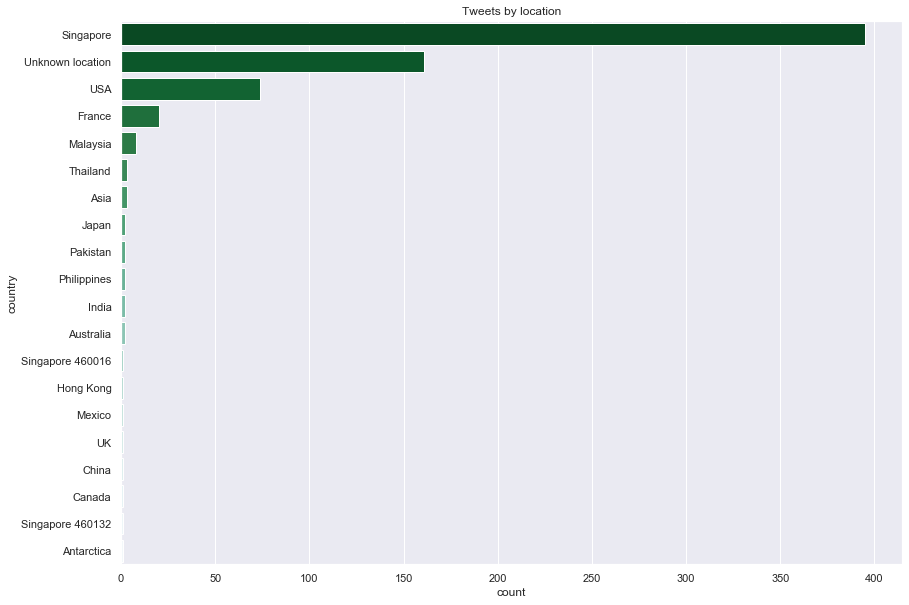

In [61]:
plt.figure(figsize=(14,10))
plt.title("Tweets by location")

sns.set(style="darkgrid")
sns.countplot(y='country', data=df, order = df['country'].value_counts().index, palette='BuGn_r')